Marklin Example: Compute and trace Taylor states in an elongated cylinder {#doc_marklin_cyl_ex}
==========
In this example we compute the Taylor state in a R=1, L=10 cylinder with Marklin and then demonstrate tracing the magnetic field and the vector potential.

In [1]:
import os
import sys
import time
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load Marklin library

To load the Marklin python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.Marklin import Marklin

## Compute equilibria

### Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
myOFT = OFT_env(nthreads=4)
taylor_solver = Marklin(myOFT)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   Marklin_vacuum
Revision id:          642ca7e
Parallelization Info:
  # of MPI tasks      =    1
  # of NUMA nodes     =    1
  # of OpenMP threads =    4
Fortran input file    = /var/folders/52/n5qxh27n4w19qxzqygz2btbw0000gn/T/oft_8963/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



## Load mesh

### Load mesh
Now we load a mesh of the desired region generated using [Cubit](https://cubit.sandia.gov/) using \ref OpenFUSIONToolkit.Marklin.Marklin.setup_mesh "setup_mesh()".

In [4]:
taylor_solver.setup_mesh(mesh_file='cyl10_mesh.h5',grid_order=2)
taylor_solver.setup(order=2,minlev=1)


**** Loading OFT mesh
  Mesh File = cyl10_mesh.h5

**** Generating grid level  1
  Generating domain linkage
  Generating boundary domain linkage
  Mesh statistics:
    Volume          =  3.125E+01
    Surface area    =  6.899E+01
    # of points     =    6867
    # of edges      =   43660
    # of faces      =   71594
    # of cells      =   34800
    # of boundary points =    1996
    # of boundary edges  =    5982
    # of boundary faces  =    3988
    # of boundary cells  =    3928
  Resolution statistics:
    hmin =  1.101E-01
    hrms =  2.077E-01
    hmax =  3.575E-01
  Surface grounded at vertex    1482


**** Creating Lagrange FE space
  Order  =    2
  Minlev =    1


**** Creating H(Curl) FE space
  Order  =    2
  Minlev =    1



### Compute eigenmodes
We now use \ref OpenFUSIONToolkit.Marklin.Marklin.compute_eig "compute_eig()" to compute the force-free eigenstates of the system $\textbf{J} = \lambda \textbf{B}$.

In [5]:
taylor_solver.compute_eig(1)


Starting calculation of Taylor states

Starting CG eigensolver
     0  3.257648E+04  5.897874E+06
     1  6.949482E+01  2.238981E+01
     2  3.830881E+01  9.402356E+00
     3  2.620479E+01  6.062719E+00
     4  2.053876E+01  4.203841E+00
     5  1.711793E+01  2.942035E+00
     6  1.485976E+01  2.281073E+00
     7  1.314429E+01  1.970061E+00
     8  1.186992E+01  1.652086E+00
     9  1.095232E+01  1.422755E+00
    10  1.025070E+01  1.217905E+00
    20  6.256863E+00  8.921829E-01
    30  4.808846E+00  4.390458E-01
    40  4.191614E+00  2.211369E-01
    50  3.922301E+00  8.678262E-02
    60  3.809193E+00  6.304317E-02
    70  3.681656E+00  8.222881E-02
    80  3.557158E+00  7.265101E-02
    90  3.474005E+00  4.064979E-02
   100  3.417581E+00  4.368518E-02
   110  3.348705E+00  4.378408E-02
   120  3.296597E+00  2.874900E-02
   130  3.262686E+00  1.987706E-02
   140  3.237965E+00  1.461614E-02
   150  3.223340E+00  6.378775E-03
   160  3.217761E+00  2.470593E-03
   170  3.215407E+00  1.09

### Save field for 3D plotting

## Save B-field and two different forms of vector potential
Here we save fields by building interpolators for each field and passing them to \ref OpenFUSIONToolkit.Marklin.Marklin.save_field "save_field()". The vector potential is saved twice with two different gauges:
  1) $A \times \hat{n} = 0$
  2) $A \cdot \hat{n} = 0$

## Trace magnetic field

### Get field evaluation object
To trace the magnetic field in python we need to retrieve an interpolation object to enable evaluation of the field at arbitrary points. This can be done using \ref OpenFUSIONToolkit.Marklin.Marklin.get_binterp "get_binterp()", where the flux is set by the `vac_facs` argument.

In [6]:
taylor_solver.setup_io()
# Save vector potential with default gauge (A_t = 0 @ wall)
ainterp_obj = taylor_solver.get_ainterp(hmode_facs=np.r_[1.0,])
taylor_solver.save_field(ainterp_obj,'A')
# Save vector potential with B-field gauge (A_n = 0 @ wall)
ainterp_obj_zero_norm = taylor_solver.get_ainterp(hmode_facs=np.r_[1.0,],bn_gauge=True)
taylor_solver.save_field(ainterp_obj_zero_norm,'A_znorm')
# Save magnetic field
binterp_obj = taylor_solver.get_binterp(hmode_facs=np.r_[1.0,])
taylor_solver.save_field(binterp_obj,'B')
_ = taylor_solver.build_XDMF()


**** Creating H^1 FE space
  Order  =    3
  Minlev =    2


**** Creating H(Curl) + Grad(H^1) FE space
  Order  =    2
  Minlev =    1

Starting CG solver
     0  0.000000E+00  0.000000E+00  1.360142E-02
     1 -5.435294E-04  2.547571E-01  3.605722E-03  1.415357E-02
     2 -5.890734E-04  2.135200E-01  3.168219E-03  1.483805E-02
     3 -6.154847E-04  1.525869E-01  2.738209E-03  1.794525E-02
     4 -6.281584E-04  1.225838E-01  1.520535E-03  1.240404E-02
     5 -6.319160E-04  1.165800E-01  9.860637E-04  8.458258E-03
     6 -6.331840E-04  1.153077E-01  6.079829E-04  5.272702E-03
     7 -6.336868E-04  1.149247E-01  4.600461E-04  4.003021E-03
     8 -6.339822E-04  1.149014E-01  4.078853E-04  3.549872E-03
     9 -6.342463E-04  1.151900E-01  3.521884E-04  3.057455E-03
    10 -6.344473E-04  1.152136E-01  2.909399E-04  2.525223E-03
    20 -6.349349E-04  1.136196E-01  5.440612E-05  4.788443E-04
    30 -6.349482E-04  1.138680E-01  9.754422E-06  8.566429E-05
    40 -6.349487E-04  1.138709E-01  1.

## Trace magnetic field and vector potential
**Note:** Vector potential with $A \cdot \hat{n} = 0$ is used for tracing, as otherwise most (all?) traces will quickly intersect the boundary.

In [7]:
def tracer_eval(y, t, interp_obj, fac):
    b = interp_obj.eval(y)
    if interp_obj.cell.value <= 0:
        return [0.0,0.0,0.0]
    else:
        return b*fac

### Perform field line tracing
Now we trace a single field line for `[0.01,0.0,4.9]`, where we trace forward and backward along the field line by applying a scale factor of `-1.0` in the second case.

In [8]:
t = np.linspace(0, 800, 1000)
# Trace magnetic field
t0 = time.perf_counter()
sol, infodict = odeint(tracer_eval, np.array([0.01,0.0,4.9]), t, args=(binterp_obj,1.0), atol=1.E-9, full_output=True)
t1 = time.perf_counter()
print("Time = {0:.3F} [s]".format(t1-t0))
print("Time/step = {0:.2E} [s]".format((t1-t0)/np.sum(infodict['nfe'])))
print()
# Trace vector potential
t0 = time.perf_counter()
sol2, infodict = odeint(tracer_eval, np.array([0.01,0.0,4.9]), t, args=(ainterp_obj_zero_norm,3.161823), atol=1.E-9, full_output=True)
t1 = time.perf_counter()
print("Time = {0:.3F} [s]".format(t1-t0))
print("Time/step = {0:.2E} [s]".format((t1-t0)/np.sum(infodict['nfe'])))

Time = 0.655 [s]
Time/step = 1.13E-08 [s]

Time = 0.340 [s]
Time/step = 1.03E-08 [s]


### Plot resulting field lines

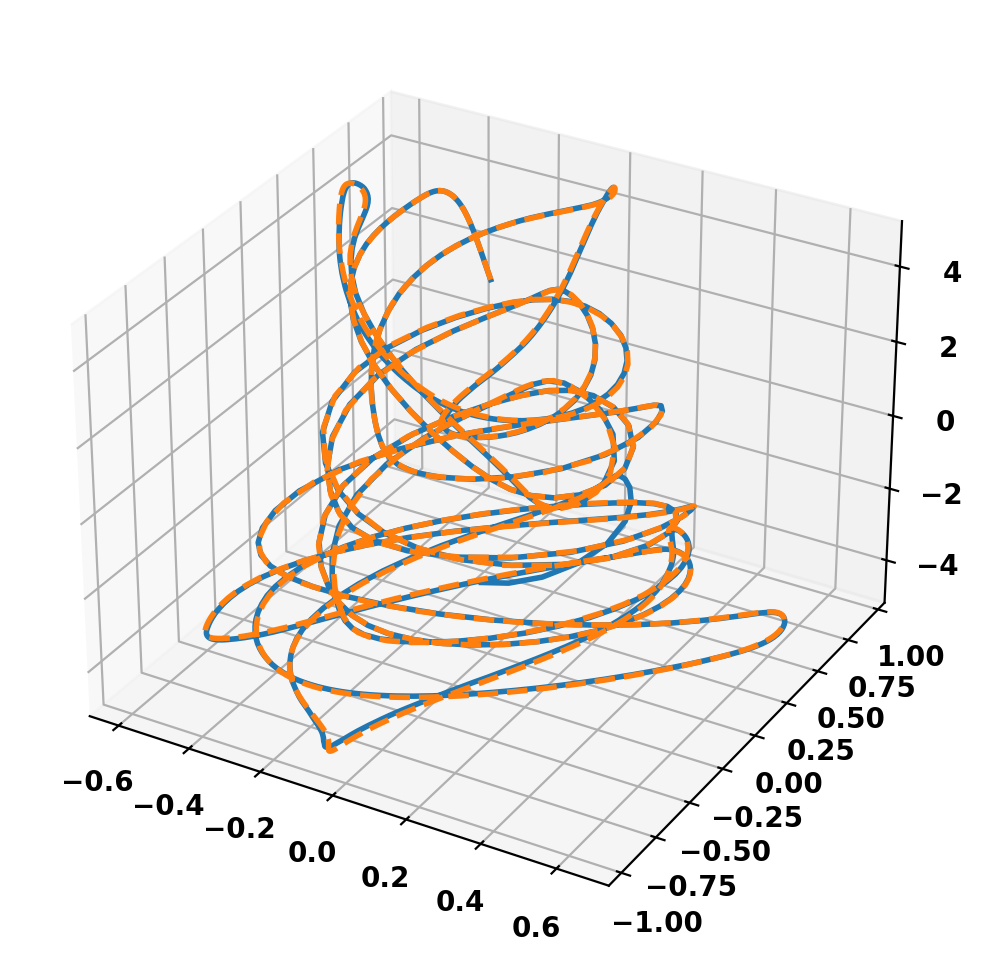

In [9]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(sol[:,0],sol[:,1],sol[:,2])
ax.plot(sol2[:,0],sol2[:,1],sol2[:,2],linestyle='--')
ax.set_aspect('auto')